# This is the notebook for DCGAN with PyTorch on CIFAR10 dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import all the packages and set the seed for reproducing

In [2]:
import os
import random

import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.utils as utils
from torch import optim
from torch.backends import cudnn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

if not os.path.exists('./output'):
    os.makedirs('./output')
if not os.path.exists('./weights'):
    os.makedirs('./weights')

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
# Enable the benchmark feature to improve the calculating efficiency
cudnn.benchmark = True
# set the manual seed
seed = 4471
random.seed(seed)
torch.manual_seed(seed)

## Load the dataset with the dataloader and set the device

In [5]:
# Load the data and set the dataloader
CIFAR10 = dataset.CIFAR10(root="./cifar10", download=True, transform=transforms.Compose(
    [transforms.Resize(64), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ]))
dataloader = DataLoader(CIFAR10, batch_size=1024, shuffle=True, num_workers=4)

Files already downloaded and verified


In [6]:
# Set the cpu device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# number of discriminator channels
num_channel = 3
# noise dimension
num_z = 100
# generator filters
num_g_fil = 64
# discriminator filters
num_d_fil = 64

## Define the generator network

In [8]:
# The data initialization function for generator and discriminator
def initial_weights(net):
    if net.__class__.__name__.find('Conv') != -1:
        net.weight.data.normal_(0, 0.02)
    elif net.__class__.__name__.find('BatchNorm') != -1:
        net.weight.data.normal_(1.0, 0.02)
        net.bias.data.fill_(0)

In [9]:
# Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # First conv2d, input shape z
            nn.ConvTranspose2d(num_z, num_g_fil * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_g_fil * 8),
            nn.LeakyReLU(inplace=True),
            # Second conv2d, size num_g_fill*8 * 4 * 4
            nn.ConvTranspose2d(num_g_fil * 8, num_g_fil * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_g_fil * 4),
            nn.LeakyReLU(inplace=True),
            # Third conv2d, size num_g_fill*4 * 8 * 8
            nn.ConvTranspose2d(num_g_fil * 4, num_g_fil * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_g_fil * 2),
            nn.LeakyReLU(inplace=True),
            # Forth conv2d, size num_g_fill*2 * 16 * 16
            nn.ConvTranspose2d(num_g_fil * 2, num_g_fil * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_g_fil * 1),
            nn.LeakyReLU(inplace=True),
            # Fifth conv2d, size num_g_fill * 32 * 32
            nn.ConvTranspose2d(num_g_fil, num_channel, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output size num_channel * 64 * 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Initial the weights of generator and print the net detail
generator = Generator().to(device)
generator.apply(initial_weights)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): ConvT

## Define the discriminator network

In [11]:
# Class of discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input num_channel * 64 * 64
            nn.Conv2d(num_channel, num_d_fil, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.15, True),
            # second conv, num_d_fill * 32 * 32
            nn.Conv2d(num_d_fil, num_d_fil * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_d_fil * 2),
            nn.LeakyReLU(0.15, True),
            # third conv, num_d_fill*2 * 16 * 16
            nn.Conv2d(num_d_fil * 2, num_d_fil * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_d_fil * 4),
            nn.LeakyReLU(0.15, True),
            # forth conv, num_d_fill*4 * 8 * 8
            nn.Conv2d(num_d_fil * 4, num_d_fil * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_d_fil * 8),
            nn.LeakyReLU(0.15, True),
            # fifth conv, num_d_fill*8 * 4 * 4
            nn.Conv2d(num_d_fil * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [12]:
# Build the discriminator and print the detail
discriminator = Discriminator().to(device)
discriminator.apply(initial_weights)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.15, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.15, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.15, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.15, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Compile the network and set the training parameters

In [13]:
# Set the criterion and optimizer
criterion = nn.BCELoss()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0004, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0004, betas=(0.5, 0.999))

In [14]:
# Set up training variables
noise = torch.randn(128, num_z, 1, 1, device=device)
real, fake = 1, 0
epochs = 301
from tqdm import tqdm
d_loss,g_loss=[],[]

## Start training!

In [15]:
for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader), 0):
        discriminator.zero_grad()
        real_gpu = data[0].to(device)
        batch_size = real_gpu.size(0)
        label = torch.full((batch_size,), real, device=device).float()

        output = discriminator(real_gpu)
        d_error_real = criterion(output, label)
        d_error_real.backward()
        d_x = output.mean().item()

        noise = torch.randn(batch_size, num_z, 1, 1, device=device)
        fake_output = generator(noise)
        label.fill_(fake)
        output = discriminator(fake_output.detach())
        d_error_fake = criterion(output, label)
        d_error_fake.backward()
        d_g_1 = output.mean().item()
        err = d_error_fake + d_error_real
        discriminator_optimizer.step()

        generator.zero_grad()
        label.fill_(real)
        output = discriminator(fake_output)
        g_error = criterion(output, label)
        g_error.backward()
        d_g_2 = output.mean().item()
        generator_optimizer.step()

        # save the output
        if i % 48 == 0 and i != 0 and epoch % 10 == 0:
            print('Epoch: [%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, epochs,err.item(),
                                                                                                g_error.item(), d_x, d_g_1, d_g_2))
            d_loss.append(err.item())
            g_loss.append(g_error.item())
            print('saving the output')
            utils.save_image(real_gpu, 'output/real_samples.png', normalize=True)
            fake_output = generator(noise)
            utils.save_image(fake_output.detach(), 'output/fake_samples_epoch_{}.png'.format(epoch), normalize=True)
    
    torch.save(generator.state_dict(), 'weights/netG_epoch_{}.pth'.format(epoch))
    torch.save(discriminator.state_dict(), 'weights/netD_epoch_{}.pth'.format(epoch))
print("\n\nTraining Finished!\n\n")

 98%|█████████▊| 48/49 [00:36<00:00,  1.44it/s]

Epoch: [0/301] Loss_D: 1.4110 Loss_G: 5.5892 D(x): 0.8605 D(G(z)): 0.5337 / 0.0317
saving the output


 98%|█████████▊| 48/49 [00:35<00:00,  1.41it/s]

Epoch: [10/301] Loss_D: 0.9982 Loss_G: 1.1050 D(x): 0.5308 D(G(z)): 0.1878 / 0.3716
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [20/301] Loss_D: 0.5714 Loss_G: 2.1494 D(x): 0.7222 D(G(z)): 0.1702 / 0.1539
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [30/301] Loss_D: 1.2768 Loss_G: 3.3150 D(x): 0.9063 D(G(z)): 0.6254 / 0.0601
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [40/301] Loss_D: 1.0238 Loss_G: 1.0718 D(x): 0.4923 D(G(z)): 0.1807 / 0.3919
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [50/301] Loss_D: 1.0738 Loss_G: 1.2298 D(x): 0.5776 D(G(z)): 0.3514 / 0.3289
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [60/301] Loss_D: 0.8596 Loss_G: 1.8676 D(x): 0.6814 D(G(z)): 0.3402 / 0.1850
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [70/301] Loss_D: 0.8669 Loss_G: 1.4939 D(x): 0.6181 D(G(z)): 0.2757 / 0.2601
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [80/301] Loss_D: 0.8247 Loss_G: 1.9034 D(x): 0.6749 D(G(z)): 0.3144 / 0.1759
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [90/301] Loss_D: 1.1259 Loss_G: 1.4375 D(x): 0.6245 D(G(z)): 0.4351 / 0.2730
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [100/301] Loss_D: 0.4997 Loss_G: 2.0938 D(x): 0.7543 D(G(z)): 0.1725 / 0.1536
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [110/301] Loss_D: 0.0496 Loss_G: 4.0855 D(x): 0.9845 D(G(z)): 0.0329 / 0.0210
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [120/301] Loss_D: 0.6755 Loss_G: 2.5264 D(x): 0.7441 D(G(z)): 0.1859 / 0.2294
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [130/301] Loss_D: 0.6991 Loss_G: 2.6603 D(x): 0.7363 D(G(z)): 0.2923 / 0.0887
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.40it/s]

Epoch: [140/301] Loss_D: 0.6096 Loss_G: 1.3653 D(x): 0.6263 D(G(z)): 0.0976 / 0.2913
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [150/301] Loss_D: 0.1261 Loss_G: 3.0084 D(x): 0.9366 D(G(z)): 0.0560 / 0.0635
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [160/301] Loss_D: 0.4859 Loss_G: 3.1874 D(x): 0.8508 D(G(z)): 0.2551 / 0.0533
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [170/301] Loss_D: 0.8379 Loss_G: 2.2025 D(x): 0.6858 D(G(z)): 0.3244 / 0.1417
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [180/301] Loss_D: 0.1730 Loss_G: 3.5319 D(x): 0.9874 D(G(z)): 0.1425 / 0.0380
saving the output


 98%|█████████▊| 48/49 [00:35<00:00,  1.40it/s]

Epoch: [190/301] Loss_D: 0.4487 Loss_G: 4.1130 D(x): 0.6794 D(G(z)): 0.0177 / 0.0251
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [200/301] Loss_D: 0.4119 Loss_G: 2.6115 D(x): 0.7605 D(G(z)): 0.1019 / 0.1010
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [210/301] Loss_D: 0.6135 Loss_G: 2.0871 D(x): 0.6225 D(G(z)): 0.0812 / 0.1603
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [220/301] Loss_D: 0.7881 Loss_G: 1.5893 D(x): 0.6596 D(G(z)): 0.2595 / 0.2510
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [230/301] Loss_D: 0.0362 Loss_G: 6.0217 D(x): 0.9679 D(G(z)): 0.0031 / 0.0037
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [240/301] Loss_D: 0.5933 Loss_G: 2.1039 D(x): 0.7598 D(G(z)): 0.2344 / 0.1675
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [250/301] Loss_D: 3.7021 Loss_G: 4.5391 D(x): 0.9735 D(G(z)): 0.9365 / 0.0239
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [260/301] Loss_D: 0.2402 Loss_G: 6.1024 D(x): 0.8039 D(G(z)): 0.0047 / 0.0044
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [270/301] Loss_D: 0.6122 Loss_G: 1.9899 D(x): 0.7431 D(G(z)): 0.2251 / 0.1929
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.41it/s]

Epoch: [280/301] Loss_D: 0.2063 Loss_G: 3.2322 D(x): 0.8908 D(G(z)): 0.0764 / 0.0666
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [290/301] Loss_D: 0.3095 Loss_G: 3.4301 D(x): 0.9048 D(G(z)): 0.1672 / 0.0540
saving the output


 98%|█████████▊| 48/49 [00:34<00:00,  1.42it/s]

Epoch: [300/301] Loss_D: 0.3677 Loss_G: 3.1186 D(x): 0.8518 D(G(z)): 0.1538 / 0.0794
saving the output


100%|██████████| 49/49 [00:38<00:00,  1.27it/s]



Training Finished!




## Display our result on CIFAR10!
---
**Note that all the images are stored in the ./output folder and all the state dict of models are stored in the ./weights folder**

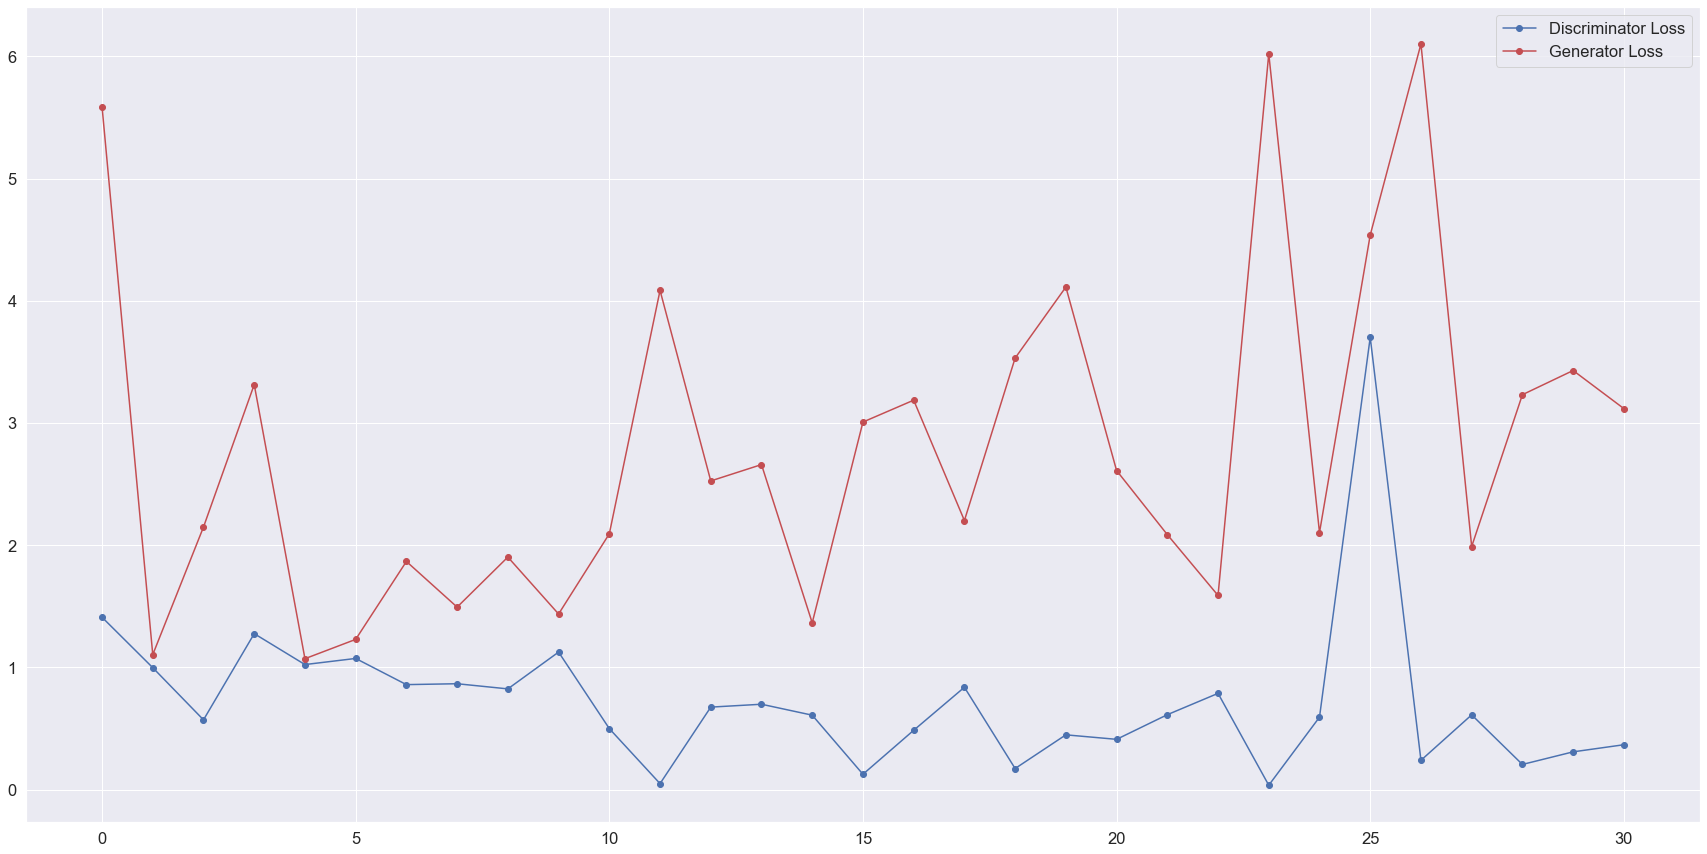

<Figure size 2160x1080 with 0 Axes>

In [23]:
# Plot the loss curve for generator and discriminator
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style="darkgrid")
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (30,15)
plt.plot(d_loss,'b-o',label="Discriminator Loss")
plt.plot(g_loss,'r-o',label="Generator Loss")
plt.legend()
plt.show()
plt.clf()

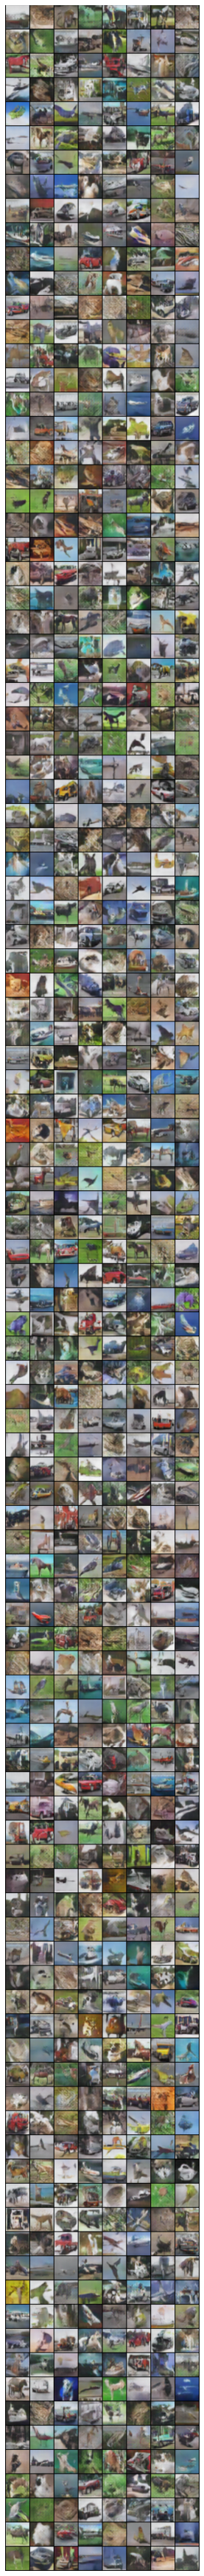

In [26]:
# Show the latest generated fake samples
from PIL import Image
plt.rcParams['figure.figsize'] = (128,64)
img=Image.open('./output/fake_samples_epoch_{}.png'.format(epochs-1))
plt.axis('off')
plt.imshow(img)